In [112]:
import pandas as pd
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
# import nomkl

In [2]:
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

In [3]:
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')

In [4]:
df.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination
0,1.000000,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,3,3,1,1,1.000000,en-es
1,1.000000,1362082044,5963,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,8,6,6,6,0.750000,en-de
2,0.750000,1362082044,5963,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,6,5,4,3,0.833333,en-de
3,0.888889,1362082044,5963,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,6,5,9,8,0.833333,en-de
4,0.800000,1362082044,5963,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,8,6,5,4,0.750000,en-de


In [5]:
df_1 = df.merge(df_words, on = 'lexeme_id', how='inner')

In [6]:
df_1

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,history_seen,history_correct,session_seen,...,gender,def,tense,POS,person,number,word,word_len,tags_list,SUBTLEX
0,1.000000,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,3,3,1,...,NaN,NaN,NaN,pr,NaN,NaN,bajo,4,['pr'],111241.0
1,1.000000,1362082044,5963,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,8,6,6,...,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",3391.0
2,0.750000,1362082044,5963,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,6,5,4,...,f,def,NaN,det,NaN,sg,die,3,"['det', 'def', 'f', 'sg']",2484854.0
3,0.888889,1362082044,5963,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,6,5,9,...,m,NaN,NaN,n,NaN,sg,mann,4,"['n', 'm', 'sg']",222707.0
4,0.800000,1362082044,5963,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,8,6,5,...,f,NaN,NaN,n,NaN,sg,frau,4,"['n', 'f', 'sg']",143725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12509996,0.800000,1363104897,368,u:i5D8,en,it,d5efc552aaea3109eb5388aa1ec8673d,6,4,5,...,NaN,def,NaN,det,NaN,sp,the,3,"['det', 'def', 'sp']",22761659.0
12509997,0.800000,1363104897,368,u:i5D8,en,it,a826c47947d68549fa81e19cafa57ba0,4,4,5,...,NaN,NaN,pres,vblex,NaN,NaN,eat,3,"['vblex', 'pres']",197654.0
12509998,1.000000,1363104897,368,u:i5D8,en,it,5e29d77697d23070a1fb92eb6c90e9b6,4,4,4,...,NaN,NaN,NaN,n,NaN,sg,bread,5,"['n', 'sg']",24828.0
12509999,0.600000,1363104897,368,u:i5D8,en,it,cdfecc9247566d40bb964a218c54c783,3,2,5,...,NaN,NaN,pres,vblex,NaN,NaN,drink,5,"['vblex', 'pres']",182580.0


In [7]:
df_2 = df_1.merge(df_users, on = ['user_id', 'lang_combination'], how='inner')

In [8]:
df_2

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,history_seen,history_correct,session_seen,...,person,number,word,word_len,tags_list,SUBTLEX,avg_user_p_recall,avg_delta,std_delta,avg_h_recall
0,1.000000,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,3,3,1,...,NaN,NaN,bajo,4,['pr'],111241.0,0.885194,2.475405e+06,2.879771e+06,0.954897
1,1.000000,1362082044,5963,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,8,6,6,...,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.614120,3.104417e+03,2.977079e+03,0.890225
2,0.750000,1362082044,5963,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,6,5,4,...,NaN,sg,die,3,"['det', 'def', 'f', 'sg']",2484854.0,0.614120,3.104417e+03,2.977079e+03,0.890225
3,0.888889,1362082044,5963,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,6,5,9,...,NaN,sg,mann,4,"['n', 'm', 'sg']",222707.0,0.614120,3.104417e+03,2.977079e+03,0.890225
4,0.800000,1362082044,5963,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,8,6,5,...,NaN,sg,frau,4,"['n', 'f', 'sg']",143725.0,0.614120,3.104417e+03,2.977079e+03,0.890225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12509996,0.800000,1363104897,368,u:i5D8,en,it,d5efc552aaea3109eb5388aa1ec8673d,6,4,5,...,NaN,sp,the,3,"['det', 'def', 'sp']",22761659.0,0.948715,5.391088e+04,6.550006e+04,0.892502
12509997,0.800000,1363104897,368,u:i5D8,en,it,a826c47947d68549fa81e19cafa57ba0,4,4,5,...,NaN,NaN,eat,3,"['vblex', 'pres']",197654.0,0.948715,5.391088e+04,6.550006e+04,0.892502
12509998,1.000000,1363104897,368,u:i5D8,en,it,5e29d77697d23070a1fb92eb6c90e9b6,4,4,4,...,NaN,sg,bread,5,"['n', 'sg']",24828.0,0.948715,5.391088e+04,6.550006e+04,0.892502
12509999,0.600000,1363104897,368,u:i5D8,en,it,cdfecc9247566d40bb964a218c54c783,3,2,5,...,NaN,NaN,drink,5,"['vblex', 'pres']",182580.0,0.948715,5.391088e+04,6.550006e+04,0.892502


In [9]:
df_2.columns

Index(['p_recall', 'timestamp', 'delta', 'user_id', 'learning_language',
       'ui_language', 'lexeme_id', 'history_seen', 'history_correct',
       'session_seen', 'session_correct', 'h_recall', 'lang_combination',
       'gender', 'def', 'tense', 'POS', 'person', 'number', 'word', 'word_len',
       'tags_list', 'SUBTLEX', 'avg_user_p_recall', 'avg_delta', 'std_delta',
       'avg_h_recall'],
      dtype='object')

In [10]:
### PREPARE DATA FOR ML 
dff = df_2.drop(columns=['timestamp', 'lexeme_id', 'word', 'user_id'])

In [11]:
dff.columns

Index(['p_recall', 'delta', 'learning_language', 'ui_language', 'history_seen',
       'history_correct', 'session_seen', 'session_correct', 'h_recall',
       'lang_combination', 'gender', 'def', 'tense', 'POS', 'person', 'number',
       'word_len', 'tags_list', 'SUBTLEX', 'avg_user_p_recall', 'avg_delta',
       'std_delta', 'avg_h_recall'],
      dtype='object')

In [12]:
categorical_cols = dff.select_dtypes(include=['object']).columns.tolist()

In [127]:
# Two approaches to handle tags 
# 1) Store tags as list, but delete rows where there are less than x occurences 
dff_1 = dff.copy()
tag_counts = dff_1['tags_list'].value_counts()
rare_threshold = 1000
dff_1['tags_list'] = dff_1['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

dff_1.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True)

<Axes: >

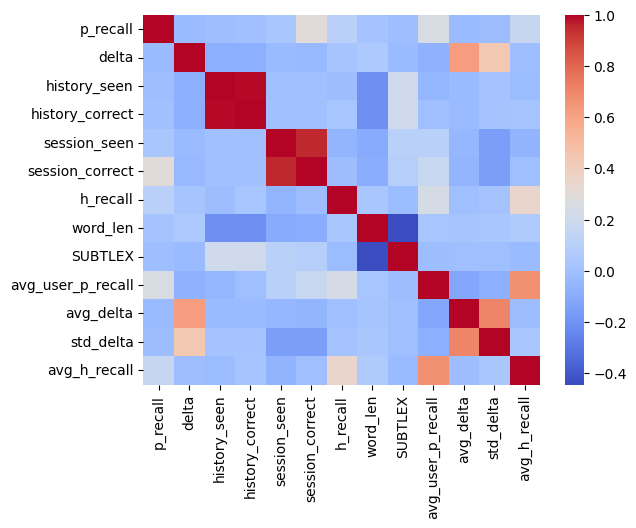

In [98]:
# Correlation between variables
sns.heatmap(dff_1.select_dtypes(exclude='O').corr(), annot=False, cmap='coolwarm')  

In [14]:
# 2) Store each tag as column, replace NaN values with a placeholder for categorical columns
# dff_2 = dff.copy()
# dff_2[categorical_cols] = dff_2[categorical_cols].fillna('missing')
# dff_2.drop(columns=['tags_list'], inplace=True)

In [129]:
# Create df without word features 
dff_t = dff_1.drop(columns=['tags_list', 'word_len', 'SUBTLEX'])

# DF original 
dff_s = dff_1.drop(columns=['SUBTLEX', 'tags_list', 'avg_delta', 'std_delta', 'avg_h_recall', 'avg_user_p_recall'])

# DF without user columns 
dff_u = dff_1.drop(columns=['avg_delta', 'std_delta', 'avg_h_recall', 'avg_user_p_recall', 'h_recall'])

In [133]:
# One-hot encode categorical variables
def ohe(df):
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([dff_1.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [134]:
def train_test_split(df):
    X = df_encoded.drop(columns='p_recall')
    y = df_encoded['p_recall']
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    return X_train, X_test, y_train, y_test

In [135]:
def cap_y(prediction): 
    return np.clip(prediction, 0, 1)

In [ ]:
dff_t_encoded = ohe(dff_t)
dff_s_encoded = ohe(dff_s)
dff_u_encoded = ohe(dff_u)

X_ta
rain_t, X_test_t, y_train_t, y_test_t = train_test_split(dff_t_encoded)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(dff_s_encoded)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(dff_u_encoded)

In [ ]:
def create_pipeline(model_type="linear", alpha=1.0, selection_method=None, n_features_to_select=None, **kwargs):
    """
    Create a pipeline for regression with optional feature selection.
    
    Returns:
    - Pipeline object
    """
    if model_type == "ridge":
        model = Ridge(alpha=alpha)
    elif model_type == "lasso":
        model = Lasso(alpha=alpha)
    else:
        model = LinearRegression()

    if selection_method == "rfe":
        feature_selector = RFE(estimator=model, step=5, n_features_to_select=n_features_to_select)
    else:
        feature_selector = "passthrough"

    steps = [
        ('scaler', StandardScaler()),
        ('feature_selection', feature_selector if selection_method else 'passthrough'),
        ('model', model)
    ]
    return Pipeline(steps)

In [ ]:
def evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name="Model"):
    """
    Train and evaluate a pipeline, returning metrics.
    """
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    y_train_pred = cap_y(y_train_pred)
    y_test_pred = cap_y(y_test_pred)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mse = mean_absolute_error(y_test, y_test_pred)
    
    print(f"{name}: Train R2 = {train_r2:.2f}, Test R2 = {test_r2:.2f}, Test MSE = {test_mse:.2f}")
    return y_test_pred, y_train_pred, test_mse, test_r2

In [ ]:
# Define Configurations for Pipelines
pipelines_config = [
    {"name": "Linear Regression", "model_type": "linear"},
    {"name": "Ridge Regression", "model_type": "ridge", "alpha": 1.0},
    {"name": "Lasso Regression", "model_type": "lasso", "alpha": 0.1},
]

pipelines_config_t_s = [
    {"name": "Linear Regression", "model_type": "linear"},
    {"name": "Ridge Regression", "model_type": "ridge", "alpha": 1.0},
    {"name": "Lasso Regression", "model_type": "lasso", "alpha": 0.1},
    {"name": "RFE (Linear)", "model_type": "linear", "selection_method": "rfe", "n_features_to_select": 10},
]


def regression_results(pipelines_config, pipeline, X_train, X_test, y_train, y_test)
    results = []
    for config in pipelines_config:
        pipeline = create_pipeline(**config)
        y_test_pred, y_train_pred, mse, r2 = evaluate_pipeline(pipeline, X_train, X_test, y_train, y_test, name=config["name"])
        results.append((config["name"], mse, r2))
    results_df = pd.DataFrame(results, columns=['Model', 'Test MSE', 'Test R2'])
    return results_df


results_all = regression_results((pipelines_config, pipeline, X_train, X_test, y_train, y_test)
results_without_word = regression_results((pipelines_config_t_s, pipeline, X_train_t, X_test_t, y_train_t, y_test_t)
results_original = regression_results((pipelines_config_t_s, pipeline, X_train_s, X_test_s, y_train_s, y_test_s)
results_without_user = regression_results((pipelines_config, pipeline, X_train_u, X_test_u, y_train_u, y_test_u)
                      


In [ ]:
# Plot Results
plt.figure(figsize=(12, 6))

# Test MSE Plot
plt.subplot(1, 2, 1)
plt.bar(results_df['Model'], results_df['Test MSE'], color='skyblue')
plt.title('Test MSE Comparison')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45)


# Test R2 Plot
plt.subplot(1, 2, 2)
plt.bar(results_df['Model'], results_df['Test R2'], color='lightgreen')
plt.title('Test R2 Comparison')
plt.ylabel('R2 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
lr_coefs = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_}).sort_values(by='Coefficient', ascending=False)
ridge_coefs = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge.coef_}).sort_values(by='Coefficient', ascending=False)
lasso_coefs = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_}).sort_values(by='Coefficient', ascending=False)

print("Top features (Linear Regression):\n", lr_coefs.head())
print("Top features (Ridge):\n", ridge_coefs.head())
print("Top features (Lasso):\n", lasso_coefs.head())

In [56]:
# Linear regression without regularization
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = models.predict(X_test)
y_train_pred =  = model.predict(X_train)

y_train_capped = cap_y(y_train_pred)
y_pred_capped = cap_y(y_pred)

print('MAE test:', mean_absolute_error(y_test, y_pred_capped))
print('MAE train', mean_absolute_error(y_train, y_train_pred)
print('R2:', r2_score(y_test, y_pred_capped)*100)

      
# Lasso Regularization
steps = [
    ('scaler', StandardScaler()),
    ('model', Lasso(alpha=0.6, fit_intercept=True))
]

lasso_model = Pipeline(steps)
lasso_model.fit(X_train, y_train)

print('Training score: {}'.format(lasso_model.score(X_train, y_train)))
print('Test score: {}'.format(lasso_model.score(X_test, y_test)))

lasso_y_pred_capped = np.clip(lasso_y_pred, 0, 1)

print('MAE:', mean_absolute_error(y_test, lasso_y_pred_capped))
print('R2:', r2_score(y_test, lasso_y_pred_capped)*100) 

Training score: 0.7509579121705349
Test score: 0.7508412762305294


NameError: name 'np' is not defined

/var/folders/_b/l_819g5924d_y00npn9gt60h0000gn/T/ipykernel_17221/3032280714.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test-y_pred_capped),bins=50);


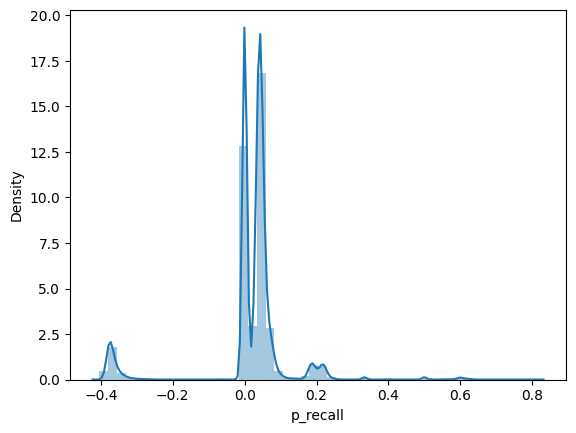

In [59]:
# Check if residuals are normally distributed 
sns.distplot((y_test-y_pred_capped),bins=50);

In [77]:
# Ridge Regularization
steps = [
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=0.6, fit_intercept=True))
]

ridge_model = Pipeline(steps)
ridge_model.fit(X_train, y_train)

print('Training score: {}'.format(ridge_model.score(X_train, y_train)))
print('Test score: {}'.format(ridge_model.score(X_test, y_test)))

ridge_y_pred = ridge_model.predict(X_test)
ridge_y_pred_capped = cap_y(ridge_y_pred)

print('MAE:', mean_absolute_error(y_test, ridge_y_pred_capped))
print('R2:', r2_score(y_test, ridge_y_pred_capped)*100) 

Training score: 0.750957912169314
Test score: 0.7508412766135982
MAE: 0.06489863011721189
MAE: 0.08283839420679034
R2: 75.08412766135983
R2: 79.79126784144313


In [80]:
# Linear with StandardScaler
steps = [
    ('scaler', StandardScaler()),
    ('model', LinearRegression())]

scaled_linear = Pipeline(steps)
scaled_linear.fit(X_train, y_train)

print('Training score: {}'.format(scaled_linear.score(X_train, y_train)))
print('Test score: {}'.format(scaled_linear.score(X_test, y_test)))

sl_y_pred = scaled_linear.predict(X_test)

sl_y_pred_capped = np.clip(lasso_y_pred, 0, 1)

print('MAE:', mean_absolute_error(y_test, sl_y_pred_capped))
print('MAE:', mean_absolute_error(y_test, sl_y_pred))

print('R2:', r2_score(y_test, sl_y_pred)*100)
print('R2:', r2_score(y_test, sl_y_pred_capped)*100) 

Training score: 0.7509579121705351
Test score: 0.7508412762288154
MAE: 0.17258450262571012
MAE: 0.08283839510845649
R2: 75.08412762288154
R2: -5.542109049461175e-05


In [ ]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MAE": f"{mean_absolute_error(y_true, y_pred):.3f}",
    }

In [ ]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients